## Project 2 

In [1]:
# import stuff
import time
import os

import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable

import torchvision
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision import datasets

from itertools import accumulate
from functools import reduce

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

data_transforms = {
    
    'train': transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]), 
    
    'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]), 


}

### Loading the Dataset

In [3]:
data_dir = 'release'
# create a dictionary that contains train and val
list_set = ['train','val']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in list_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle= True) for x in list_set}

trainloader, valloader = dataloaders[list_set[0]], dataloaders[list_set[1]]

dataset_sizes = {x: len(image_datasets[x]) for x in list_set}

class_names = image_datasets[list_set[0]].classes

print("Classes = {}".format(class_names))
print("Num of Classes = {}".format(len(class_names)))
print("There are {} iterations in the training set".format(len(dataloaders[list_set[0]])))
print("There are {} iterations in the valdation set".format(len(dataloaders[list_set[1]])))
print("There are {} training images".format(dataset_sizes[list_set[0]]))
print("There are {} validation images".format(dataset_sizes[list_set[1]]))

Classes = ['apple', 'avocado', 'banana', 'blueberry', 'cherry', 'dragonfruit', 'grape', 'kiwifruit', 'lemon', 'orange', 'papaya', 'peach', 'pear', 'pineapple', 'plum', 'pomegranate', 'rockmelon', 'strawberry']
Num of Classes = 18
There are 605 iterations in the training set
There are 89 iterations in the valdation set
There are 2417 training images
There are 355 validation images


### Loading the Resnet

In [11]:
net = torchvision.models.resnet50(pretrained=True) # change this to some other model
print(net)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\yxia2172/.torch\models\resnet50-19c8e357.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
# only train the last layer
# freeze all the layers
# cancels backpropagation

for param in net.parameters():
    param.requires_grad = False

In [13]:
num_ftrs = net.fc.in_features # get number of input features of the last fc layer

net.fc = nn.Linear(num_ftrs,18) # set the last fc to 18
print(net.fc)

Linear(in_features=2048, out_features=18, bias=True)


In [14]:
if torch.cuda.is_available():
    net = net.cuda()
torch.cuda.is_available()

True

### Define a Loss function and optimizer

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [16]:
# lr scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# step_size = 7: change learning rate every 7 epochs.
# gamma = 0.1: learning rate * gamma when changing.
print(scheduler.base_lrs)

[0.001]


### Visualise the Training

In [17]:
iteration = 0
correct = 0

for inputs, labels in dataloaders['train']:
    
    if iteration ==1:
        break
        
    inputs = Variable(inputs)
    labels = Variable(labels)
    
    if torch.cuda.is_available():
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()    
        
    print("For one iteration this is what happens = ")
    print("Input Shape: ",inputs.shape)
    print("Labels Shape: ",labels.shape)
    print("Labels are: {}".format(labels))
    
    
    if torch.cuda.is_available():
        net = net.cuda()
    output = net(inputs)
    
    print("Output Tensor:",output)
    print("Output Shape: ",output.shape)
    
    _, predicted = torch.max(output,1)
    
    print("Predicted:",predicted)
    print("Predicted Shape:",predicted.shape)
    
    correct += (predicted==labels).sum()
    
    print("Correct Predictions:",correct)
    
    iteration+=1

For one iteration this is what happens = 
Input Shape:  torch.Size([4, 3, 224, 224])
Labels Shape:  torch.Size([4])
Labels are: tensor([14,  6,  9,  6], device='cuda:0')
Output Tensor: tensor([[ 0.0813, -0.0808, -0.5469,  0.3581, -0.4920,  0.5630,  0.5305,  0.1314,
         -0.5702,  0.1609, -0.0811, -0.0844, -0.3801,  0.6220, -0.4407, -0.0925,
          0.0493,  0.2029],
        [ 0.1702, -0.2381, -0.4562,  0.1809, -0.5718,  0.3801,  0.5152,  0.3682,
         -0.5060, -0.1347, -0.1571, -0.1316, -0.2507,  0.3037, -0.2657,  0.1853,
         -0.0301, -0.4892],
        [ 0.5440, -0.4690, -0.4388,  0.4350, -0.3043,  0.3354,  0.0843,  0.1430,
         -0.5798,  0.2697, -0.5351,  0.0720, -0.3192,  0.1133, -0.1633,  0.2421,
         -0.0666,  0.0038],
        [ 0.5087, -0.0674, -0.5599,  0.2013, -0.8878,  0.1988,  0.2097,  0.0697,
         -0.3198, -0.3890, -0.2875,  0.1909, -0.0382,  0.0796, -0.1537,  0.6663,
         -0.2056,  0.1835]], device='cuda:0', grad_fn=<ThAddmmBackward>)
Output Sha

### Train the Network

In [18]:
loss_list = []
validation_list = []
test_accuracy_list = []

for epoch in range(20):  # change this to 20
    
    correct = 0
    total = 0

    running_loss = 0.0
    validation_loss = 0.0
    
    scheduler.step()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    
            
            loss_list.append(running_loss/50)
            
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
        
    for i, data in enumerate(valloader, 0):
        
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)
        val_loss = criterion(outputs, labels)
        validation_loss += val_loss.item()
        
        if i % 10 == 9:    
            
            validation_list.append(validation_loss/10)
            
            print('[%d, %5d] validation loss: %.3f' %
                  (epoch + 1, i + 1, validation_loss/10))
            
            validation_loss = 0.0
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()    
    
    print("Test Accuracy: {:.3f}%".format(100*correct/total))
    
    test_accuracy = 100*correct/total
    
    test_accuracy_list.append(test_accuracy)
        
print('Finished Training')

[1,    50] running loss: 3.020
[1,   100] running loss: 2.795
[1,   150] running loss: 2.311
[1,   200] running loss: 2.241
[1,   250] running loss: 2.021
[1,   300] running loss: 1.916
[1,   350] running loss: 1.729
[1,   400] running loss: 1.673
[1,   450] running loss: 1.678
[1,   500] running loss: 1.464
[1,   550] running loss: 1.429
[1,   600] running loss: 1.406
[1,    10] validation loss: 1.309
[1,    20] validation loss: 1.617
[1,    30] validation loss: 1.308
[1,    40] validation loss: 1.230
[1,    50] validation loss: 1.203
[1,    60] validation loss: 1.473
[1,    70] validation loss: 1.143
[1,    80] validation loss: 1.238
Test Accuracy: 61.408%
[2,    50] running loss: 1.325
[2,   100] running loss: 1.298
[2,   150] running loss: 1.272
[2,   200] running loss: 1.132
[2,   250] running loss: 1.127
[2,   300] running loss: 1.176
[2,   350] running loss: 1.197
[2,   400] running loss: 1.233
[2,   450] running loss: 1.104
[2,   500] running loss: 1.178
[2,   550] running loss

[13,   300] running loss: 0.653
[13,   350] running loss: 0.619
[13,   400] running loss: 0.597
[13,   450] running loss: 0.607
[13,   500] running loss: 0.520
[13,   550] running loss: 0.699
[13,   600] running loss: 0.608
[13,    10] validation loss: 0.691
[13,    20] validation loss: 0.708
[13,    30] validation loss: 0.896
[13,    40] validation loss: 0.788
[13,    50] validation loss: 0.908
[13,    60] validation loss: 0.609
[13,    70] validation loss: 0.659
[13,    80] validation loss: 0.676
Test Accuracy: 75.775%
[14,    50] running loss: 0.568
[14,   100] running loss: 0.572
[14,   150] running loss: 0.603
[14,   200] running loss: 0.570
[14,   250] running loss: 0.514
[14,   300] running loss: 0.532
[14,   350] running loss: 0.796
[14,   400] running loss: 0.607
[14,   450] running loss: 0.651
[14,   500] running loss: 0.632
[14,   550] running loss: 0.718
[14,   600] running loss: 0.531
[14,    10] validation loss: 0.795
[14,    20] validation loss: 0.374
[14,    30] validat

##### Visualise the loss and accuracy
Using the loss of both training data and validation data to evaluate the model.

running_lost_list_per_epoch= [1.4063345575332642, 0.9477423322200775, 0.9583433401584626, 0.9719064617156983, 0.91597043633461, 0.6328254091739655, 0.6953170883655548, 0.717123076915741, 0.560979391336441, 0.5348368382453919, 0.623328093290329, 0.7202651226520538, 0.6081545555591583, 0.5314273059368133, 0.5568399727344513, 0.6235533785820008, 0.633513206243515, 0.5346210443973541, 0.5117947268486023, 0.5021979677677154]
running_lost_list_per_epoch= [1.2381267488002776, 0.9338259756565094, 0.8957913219928741, 0.8473927676677704, 1.302335077524185, 0.6330998539924622, 0.8064699351787568, 0.7091413140296936, 0.5872002184391022, 0.6733689546585083, 0.6462319135665894, 0.7445514976978302, 0.6757339239120483, 0.6085427641868592, 0.3934172034263611, 0.9345060765743256, 0.6576687872409821, 0.879808783531189, 0.49212793707847596, 0.7070457994937897]


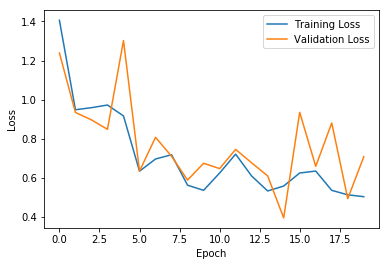

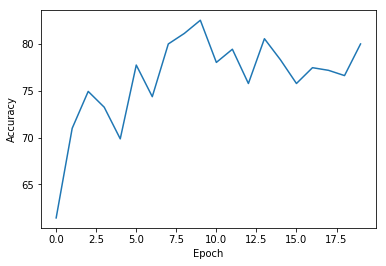

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

running_loss_list_per_epoch = loss_list[11::12]

print('running_lost_list_per_epoch=',running_loss_list_per_epoch)

validation_loss_list_per_epoch = validation_list[7::8]

print('running_lost_list_per_epoch=',validation_loss_list_per_epoch)

plt.plot(range(len(running_loss_list_per_epoch)),running_loss_list_per_epoch)

plt.plot(range(len(validation_loss_list_per_epoch)),validation_loss_list_per_epoch) 

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.figure()

plt.plot(range(len(test_accuracy_list)), test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.figure()

### Eval the trained network

In [20]:
# net.eval()
def eval_net(net, valloader):
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for data in valloader:
            
            images, labels = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100*correct/total))

eval_net(net, valloader)

Test Accuracy: 80.845 %


### Visualise Our Predictions

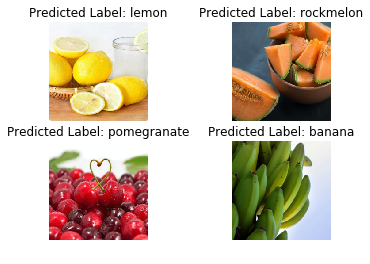

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0

with torch.no_grad():
    for(images, labels) in dataloaders['val']:
        if shown_batch ==1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = net(images) # the output has shape (4,18)
        _,preds = torch.max(outputs,1) # the pred has shape [0-17,0-17,0-17,0-17]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i] # get the tensor of the image and put it to cpu
            inp = input_img.numpy().transpose((1,2,0)) # if we have (1,2,3) -> (2,3,1)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = (std*inp) + mean
            inp = np.clip(inp,0,1)
            plt.imshow(inp)

### References
- https://www.w3schools.com/python/python_dictionaries.asp
- https://www.programcreek.com/python/example/105102/torchvision.datasets.ImageFolder
- https://stackoverflow.com/questions/14826888/python-os-path-join-on-a-list
- https://github.com/pytorch/vision/tree/master/torchvision/models

In [22]:
# save the model
torch.save(net.state_dict(),'resnet50.pth')

In [ ]:
# load the model
net = Network(pretrained = True)
net.load_state_dict(torch.load('resnet18.pth'))
net.eval()

### Stuff

In [16]:
# simple stuff
#animals = {
    #"lion": "roar",
    #"tiger": "roarrr"
#}
dog = {x: 'cat' + x for x in ['thelion','thetiger']}
print(dog)

{'thelion': 'catthelion', 'thetiger': 'catthetiger'}


In [17]:
listoflists = []

for i in range(0,2):
    sublist = []
    
    for j in range(0,10):
        
        sublist.append([i,j])
        
    listoflists.append(sublist)
    
print(listoflists)

[[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], [[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9]]]


In [18]:
dataload_ = {
    'the_train' : [[1,2],[2,5],[3,6]],
    3 : 4,
    5 : 6,
    7 : 8
}

for in_, la_ in dataload_['the_train']:
    
    print("inputs = {0} labels = {1}".format(in_,la_))

# for inputs,labels in dataloaders['train']:


inputs = 1 labels = 2
inputs = 2 labels = 5
inputs = 3 labels = 6


In [19]:
"int: {:d};  hex: {:#x};  oct: {:#o};  bin: {:#b}".format(42,9,10,11)

'int: 42;  hex: 0x9;  oct: 0o12;  bin: 0b1011'